# **CS 6375 Project 3: Deep Learning for MNIST and CIFAR-10**
This project implements and evaluates Multilayer Perceptrons (MLPs) and Convolutional Neural Networks (CNNs) on two image classification datasets (MNIST and CIFAR-10) using PyTorch.

**Strategy for Efficiency:**
- Hyperparameter tuning: 5-10 epochs (quick search)
- Final training: 20-30 epochs (thorough)
- This should complete tuning in ~1 hour total, final training in minutes

# **Table of Contents**
[Setup](#section-0)

[Data Loading & Preprocessing](#section-1)

[Helper Functions (Training & Evaluation)](#section-1-5)

[MLP on MNIST](#section-2)

[CNN on MNIST](#section-3)

[MLP on CIFAR-10](#section-4)

[CNN on CIFAR-10](#section-5)

[Summary of All Results](#section-6)

<a id='section-0'></a>
# **Section 0: Setup**

In [ ]:
# Core PyTorch libraries
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
print("Core PyTorch installed!")

Core PyTorch installed!


In [ ]:
# PyTorch vision library
import torchvision
import torchvision.transforms as transforms
print("Torchvision installed!")

Torchvision installed!


In [ ]:
# Standard Python libraries
import numpy as np
import matplotlib.pyplot as plt
import time
from collections import defaultdict
import pandas as pd
print("Standard libraries installed!")

Standard libraries installed!


In [ ]:
# Set random seeds for reproducibility
torch.manual_seed(42)
np.random.seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed(42)
    torch.cuda.manual_seed_all(42)
print("Seeds set to 42 for reproducibility!")

Seeds set to 42 for reproducibility!


In [ ]:
# Check for MPS (Apple Silicon GPU), then CUDA, then CPU
if torch.backends.mps.is_available():
    device = torch.device('mps')
    print("Using device: MPS (Apple Silicon GPU)")
elif torch.cuda.is_available():
    device = torch.device('cuda')
    print(f"Using device: CUDA - {torch.cuda.get_device_name(0)}")
else:
    device = torch.device('cpu')
    print("Using device: CPU")

print(f"Device: {device}")

Using device: CUDA - NVIDIA L4
Device: cuda


<a id='section-1'></a>
# **Section 1: Data Loading & Preprocessing**

In [ ]:
# MNIST: grayscale images (1 channel), 28x28 pixels
# Normalize to [-1, 1] range for better training
mnist_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])
print("MNIST transform established!")

MNIST transform established!


In [ ]:
# CIFAR-10: RGB images (3 channels), 32x32 pixels
# Normalize each channel to [-1, 1] range
cifar_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])
print("CIFAR-10 transform established!")

CIFAR-10 transform established!


In [ ]:
# Load MNIST dataset
print("Loading MNIST dataset...")
mnist_full_train = torchvision.datasets.MNIST(
    root='./data',
    train=True,
    download=True,
    transform=mnist_transform
)
mnist_test = torchvision.datasets.MNIST(
    root='./data',
    train=False,
    download=True,
    transform=mnist_transform
)
print("\nMNIST dataset loaded!")

Loading MNIST dataset...

MNIST dataset loaded!


In [ ]:
# Split MNIST into train (50k) and validation (10k) as specified
mnist_train, mnist_val = random_split(
    mnist_full_train,
    [50000, 10000],
    generator=torch.Generator().manual_seed(42)
)

print(f"MNIST - Train: {len(mnist_train)}, Val: {len(mnist_val)}, Test: {len(mnist_test)}")

MNIST - Train: 50000, Val: 10000, Test: 10000


In [ ]:
# Load CIFAR-10 dataset
print("Loading CIFAR-10 dataset...")
cifar_full_train = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=cifar_transform
)
cifar_test = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=cifar_transform
)
print("CIFAR-10 dataset loaded!")

Loading CIFAR-10 dataset...
CIFAR-10 dataset loaded!


In [ ]:
# Split CIFAR-10 into train (45k) and validation (5k) as specified
cifar_train, cifar_val = random_split(
    cifar_full_train,
    [45000, 5000],
    generator=torch.Generator().manual_seed(42)
)

print(f"CIFAR-10 - Train: {len(cifar_train)}, Val: {len(cifar_val)}, Test: {len(cifar_test)}")

CIFAR-10 - Train: 45000, Val: 5000, Test: 10000


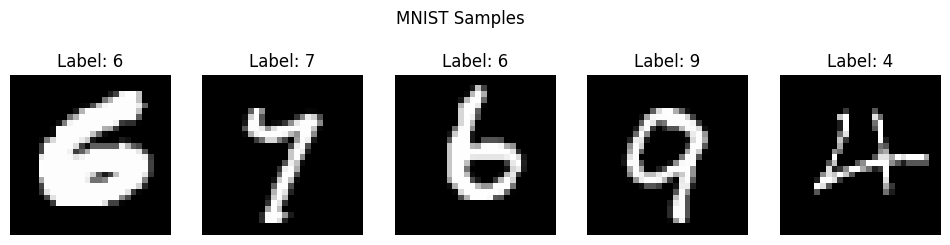

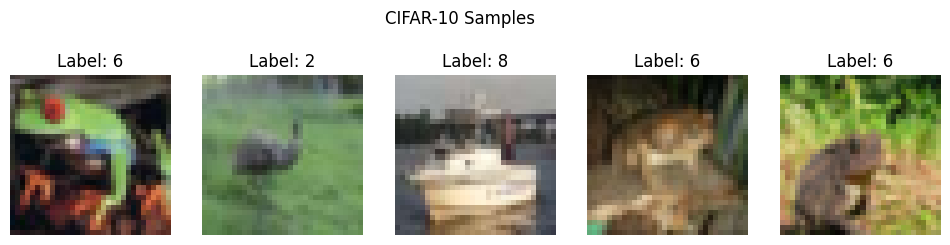

In [ ]:
# Visualize a few samples
def show_samples(dataset, dataset_name, n=5):
    fig, axes = plt.subplots(1, n, figsize=(12, 3))
    for i in range(n):
        img, label = dataset[i]
        # Denormalize for display
        img = img * 0.5 + 0.5
        img = img.permute(1, 2, 0)
        axes[i].imshow(img.squeeze(), cmap='gray' if dataset_name == 'MNIST' else None)
        axes[i].set_title(f'Label: {label}')
        axes[i].axis('off')
    plt.suptitle(f'{dataset_name} Samples')
    plt.show()

show_samples(mnist_train, 'MNIST')
show_samples(cifar_train, 'CIFAR-10')

<a id='section-1-5'></a>
# **Section 1.5: Helper Functions (Modular Training & Evaluation)**

These reusable functions will be used for all experiments to avoid code duplication.

In [ ]:
def train_epoch(model, train_loader, criterion, optimizer, device):
    """Train for one epoch and return average loss and accuracy."""
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = 100 * correct / total
    return epoch_loss, epoch_acc

In [ ]:
def evaluate(model, data_loader, criterion, device):
    """Evaluate model and return loss and accuracy."""
    model.eval()
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    avg_loss = running_loss / total
    accuracy = 100 * correct / total
    return avg_loss, accuracy

In [ ]:
def train_model(model, train_loader, val_loader, criterion, optimizer,
                device, num_epochs, early_stopping_patience=5, verbose=False):
    """
    Train a model with early stopping.
    Returns: best_val_acc, best_model_state, training_time
    """
    start_time = time.time()
    best_val_acc = 0.0
    best_model_state = None
    patience_counter = 0

    for epoch in range(num_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        val_loss, val_acc = evaluate(model, val_loader, criterion, device)

        if verbose and (epoch % 5 == 0 or epoch == num_epochs - 1):
            print(f'Epoch {epoch+1}/{num_epochs}: '
                  f'Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%')

        # Save best model
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_state = model.state_dict().copy()
            patience_counter = 0
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= early_stopping_patience:
            if verbose:
                print(f'Early stopping at epoch {epoch+1}')
            break

    training_time = (time.time() - start_time) / 60  # in minutes
    return best_val_acc, best_model_state, training_time

In [ ]:
def hyperparameter_search(model_class, model_kwargs, train_dataset, val_dataset,
                         hyperparams_list, device, input_size, num_classes,
                         tuning_epochs=7, num_runs=3):
    """
    Perform hyperparameter search with multiple runs for stability.

    Args:
        model_class: Model class to instantiate
        model_kwargs: Fixed model architecture parameters
        train_dataset, val_dataset: Training and validation datasets
        hyperparams_list: List of dicts with hyperparameters to try
        device: torch device
        input_size: Input size for the model
        num_classes: Number of output classes
        tuning_epochs: Number of epochs for quick tuning (default: 7)
        num_runs: Number of runs per config for stability (default: 3)

    Returns:
        results_df: DataFrame with all results
        best_config: Best hyperparameter configuration
    """
    results = []

    print(f"Testing {len(hyperparams_list)} configurations with {num_runs} runs each...")
    print(f"Using {tuning_epochs} epochs for quick hyperparameter search\n")

    for idx, hparams in enumerate(hyperparams_list):
        print(f"Config {idx+1}/{len(hyperparams_list)}: {hparams}")

        val_accs = []
        times = []

        # Multiple runs for stability
        for run in range(num_runs):
            # Create fresh model
            model = model_class(input_size=input_size, num_classes=num_classes, **model_kwargs)
            model = model.to(device)

            # Create dataloaders
            train_loader = DataLoader(train_dataset, batch_size=hparams['batch_size'],
                                     shuffle=True, num_workers=2)
            val_loader = DataLoader(val_dataset, batch_size=hparams['batch_size'],
                                   shuffle=False, num_workers=2)

            # Setup optimizer
            if hparams['optimizer'] == 'SGD':
                optimizer = optim.SGD(model.parameters(), lr=hparams['lr'], momentum=0.9)
            else:  # Adam
                optimizer = optim.Adam(model.parameters(), lr=hparams['lr'])

            criterion = nn.CrossEntropyLoss()

            # Train
            best_val_acc, _, training_time = train_model(
                model, train_loader, val_loader, criterion, optimizer,
                device, num_epochs=tuning_epochs, early_stopping_patience=3,
                verbose=False
            )

            val_accs.append(best_val_acc)
            times.append(training_time)

        # Calculate statistics
        mean_acc = np.mean(val_accs)
        std_acc = np.std(val_accs)
        mean_time = np.mean(times)

        print(f"  Val Acc: {mean_acc:.2f}% (±{std_acc:.2f}%), Time: {mean_time:.2f} min\n")

        results.append({
            'lr': hparams['lr'],
            'batch_size': hparams['batch_size'],
            'optimizer': hparams['optimizer'],
            'dropout': hparams['dropout'],
            'val_acc_mean': mean_acc,
            'val_acc_std': std_acc,
            'time_min': mean_time
        })

    results_df = pd.DataFrame(results)

    # Find best configuration
    best_idx = results_df['val_acc_mean'].idxmax()
    best_config = hyperparams_list[best_idx]

    print("\n" + "="*60)
    print("BEST CONFIGURATION:")
    print(best_config)
    print(f"Validation Accuracy: {results_df.loc[best_idx, 'val_acc_mean']:.2f}% "
          f"(±{results_df.loc[best_idx, 'val_acc_std']:.2f}%)")
    print("="*60 + "\n")

    return results_df, best_config

In [ ]:
def final_training(model_class, model_kwargs, train_dataset, val_dataset, test_dataset,
                  best_config, device, input_size, num_classes, final_epochs=25):
    """
    Train final model on train+val data using best hyperparameters.

    Returns:
        test_accuracy: Final test accuracy
        training_time: Total training time in minutes
    """
    print("\n" + "="*60)
    print("FINAL TRAINING ON COMBINED TRAIN+VAL DATA")
    print("="*60)
    print(f"Using {final_epochs} epochs for thorough training")
    print(f"Configuration: {best_config}\n")

    # Combine train and val datasets
    from torch.utils.data import ConcatDataset
    combined_dataset = ConcatDataset([train_dataset, val_dataset])

    # Create final model
    model = model_class(input_size=input_size, num_classes=num_classes, **model_kwargs)
    model = model.to(device)

    # Create dataloaders
    train_loader = DataLoader(combined_dataset, batch_size=best_config['batch_size'],
                             shuffle=True, num_workers=2)
    test_loader = DataLoader(test_dataset, batch_size=best_config['batch_size'],
                            shuffle=False, num_workers=2)

    # Setup optimizer
    if best_config['optimizer'] == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=best_config['lr'], momentum=0.9)
    else:
        optimizer = optim.Adam(model.parameters(), lr=best_config['lr'])

    criterion = nn.CrossEntropyLoss()

    # Train
    start_time = time.time()
    for epoch in range(final_epochs):
        train_loss, train_acc = train_epoch(model, train_loader, criterion, optimizer, device)
        if (epoch + 1) % 5 == 0 or epoch == final_epochs - 1:
            print(f'Epoch {epoch+1}/{final_epochs}: Train Acc: {train_acc:.2f}%')

    training_time = (time.time() - start_time) / 60

    # Evaluate on test set
    test_loss, test_acc = evaluate(model, test_loader, criterion, device)

    print(f"\nTest Accuracy: {test_acc:.2f}%")
    print(f"Training Time: {training_time:.2f} minutes")
    print("="*60 + "\n")

    return test_acc, training_time

<a id='section-2'></a>
# **Section 2: MLP on MNIST**

In [ ]:
class MLP(nn.Module):
    """Flexible MLP architecture with variable depth."""
    def __init__(self, input_size, num_classes, hidden_sizes, dropout_rate=0.2):
        super(MLP, self).__init__()

        layers = []
        prev_size = input_size

        # Build hidden layers
        for hidden_size in hidden_sizes:
            layers.append(nn.Linear(prev_size, hidden_size))
            layers.append(nn.ReLU())
            layers.append(nn.Dropout(dropout_rate))
            prev_size = hidden_size

        # Output layer
        layers.append(nn.Linear(prev_size, num_classes))

        self.network = nn.Sequential(*layers)
        self.flatten = nn.Flatten()

    def forward(self, x):
        x = self.flatten(x)
        return self.network(x)

print("MLP class defined!")

MLP class defined!


In [ ]:
# Define the three MLP architectures
mlp_architectures = {
    'shallow': {'hidden_sizes': [128]},
    'medium': {'hidden_sizes': [512, 256, 128]},
    'deep': {'hidden_sizes': [512, 512, 256, 256, 128]}  # 5 hidden layers
}

print("MLP architectures defined:")
for name, arch in mlp_architectures.items():
    print(f"  {name}: {len(arch['hidden_sizes'])} hidden layers - {arch['hidden_sizes']}")

MLP architectures defined:
  shallow: 1 hidden layers - [128]
  medium: 3 hidden layers - [512, 256, 128]
  deep: 5 hidden layers - [512, 512, 256, 256, 128]


In [ ]:
# Define hyperparameter search space (10-12 meaningful configurations)
# We'll use a smart subset rather than exhaustive search
mlp_mnist_hyperparams = [
    # Baseline configs
    {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2},
    {'lr': 0.001, 'batch_size': 128, 'optimizer': 'Adam', 'dropout': 0.2},

    # Test different learning rates with Adam
    {'lr': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2},
    {'lr': 0.0001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2},

    # Test SGD optimizer
    {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2},
    {'lr': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2},

    # Test different dropout rates
    {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.5},
    {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.0},

    # Test different batch sizes
    {'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'dropout': 0.2},
    {'lr': 0.001, 'batch_size': 256, 'optimizer': 'Adam', 'dropout': 0.2},

    # Additional combinations
    {'lr': 0.01, 'batch_size': 128, 'optimizer': 'SGD', 'dropout': 0.3},
    {'lr': 0.0001, 'batch_size': 128, 'optimizer': 'Adam', 'dropout': 0.3},
]

print(f"Defined {len(mlp_mnist_hyperparams)} hyperparameter configurations for search")

Defined 12 hyperparameter configurations for search


In [ ]:
# Dictionary to store all results
mnist_mlp_results = {}

# MNIST input/output specs
mnist_input_size = 28 * 28
mnist_num_classes = 10

## 2.1: Shallow MLP (1 hidden layer)

In [ ]:
print("\n" + "#"*60)
print("# MNIST - SHALLOW MLP (1 HIDDEN LAYER)")
print("#"*60 + "\n")

results_df, best_config = hyperparameter_search(
    model_class=MLP,
    model_kwargs=mlp_architectures['shallow'],
    train_dataset=mnist_train,
    val_dataset=mnist_val,
    hyperparams_list=mlp_mnist_hyperparams,
    device=device,
    input_size=mnist_input_size,
    num_classes=mnist_num_classes,
    tuning_epochs=7,
    num_runs=3
)

test_acc, train_time = final_training(
    model_class=MLP,
    model_kwargs=mlp_architectures['shallow'],
    train_dataset=mnist_train,
    val_dataset=mnist_val,
    test_dataset=mnist_test,
    best_config=best_config,
    device=device,
    input_size=mnist_input_size,
    num_classes=mnist_num_classes,
    final_epochs=25
)

mnist_mlp_results['shallow'] = {
    'search_results': results_df,
    'best_config': best_config,
    'test_accuracy': test_acc,
    'training_time': train_time
}


############################################################
# MNIST - SHALLOW MLP (1 HIDDEN LAYER)
############################################################

Testing 12 configurations with 3 runs each...
Using 7 epochs for quick hyperparameter search

Config 1/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 96.39% (±0.06%), Time: 0.80 min

Config 2/12: {'lr': 0.001, 'batch_size': 128, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 96.04% (±0.07%), Time: 0.74 min

Config 3/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 91.83% (±0.57%), Time: 0.68 min

Config 4/12: {'lr': 0.0001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 93.67% (±0.13%), Time: 0.79 min

Config 5/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 96.70% (±0.07%), Time: 0.80 min

Config 6/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 92.76% (±0.09%), Time:

## 2.2: Medium MLP (3 hidden layers)

In [ ]:
print("\n" + "#"*60)
print("# MNIST - MEDIUM MLP (3 HIDDEN LAYERS)")
print("#"*60 + "\n")

results_df, best_config = hyperparameter_search(
    model_class=MLP,
    model_kwargs=mlp_architectures['medium'],
    train_dataset=mnist_train,
    val_dataset=mnist_val,
    hyperparams_list=mlp_mnist_hyperparams,
    device=device,
    input_size=mnist_input_size,
    num_classes=mnist_num_classes,
    tuning_epochs=7,
    num_runs=3
)

test_acc, train_time = final_training(
    model_class=MLP,
    model_kwargs=mlp_architectures['medium'],
    train_dataset=mnist_train,
    val_dataset=mnist_val,
    test_dataset=mnist_test,
    best_config=best_config,
    device=device,
    input_size=mnist_input_size,
    num_classes=mnist_num_classes,
    final_epochs=25
)

mnist_mlp_results['medium'] = {
    'search_results': results_df,
    'best_config': best_config,
    'test_accuracy': test_acc,
    'training_time': train_time
}


############################################################
# MNIST - MEDIUM MLP (3 HIDDEN LAYERS)
############################################################

Testing 12 configurations with 3 runs each...
Using 7 epochs for quick hyperparameter search

Config 1/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 96.77% (±0.07%), Time: 0.80 min

Config 2/12: {'lr': 0.001, 'batch_size': 128, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 97.04% (±0.19%), Time: 0.74 min

Config 3/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 89.32% (±0.25%), Time: 0.66 min

Config 4/12: {'lr': 0.0001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 96.30% (±0.21%), Time: 0.79 min

Config 5/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 96.98% (±0.05%), Time: 0.79 min

Config 6/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 93.48% (±0.17%), Time:

## 2.3: Deep MLP (5 hidden layers)

In [ ]:
print("\n" + "#"*60)
print("# MNIST - DEEP MLP (5 HIDDEN LAYERS)")
print("#"*60 + "\n")

results_df, best_config = hyperparameter_search(
    model_class=MLP,
    model_kwargs=mlp_architectures['deep'],
    train_dataset=mnist_train,
    val_dataset=mnist_val,
    hyperparams_list=mlp_mnist_hyperparams,
    device=device,
    input_size=mnist_input_size,
    num_classes=mnist_num_classes,
    tuning_epochs=7,
    num_runs=3
)

test_acc, train_time = final_training(
    model_class=MLP,
    model_kwargs=mlp_architectures['deep'],
    train_dataset=mnist_train,
    val_dataset=mnist_val,
    test_dataset=mnist_test,
    best_config=best_config,
    device=device,
    input_size=mnist_input_size,
    num_classes=mnist_num_classes,
    final_epochs=25
)

mnist_mlp_results['deep'] = {
    'search_results': results_df,
    'best_config': best_config,
    'test_accuracy': test_acc,
    'training_time': train_time
}


############################################################
# MNIST - DEEP MLP (5 HIDDEN LAYERS)
############################################################

Testing 12 configurations with 3 runs each...
Using 7 epochs for quick hyperparameter search

Config 1/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 96.45% (±0.12%), Time: 0.79 min

Config 2/12: {'lr': 0.001, 'batch_size': 128, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 96.47% (±0.18%), Time: 0.75 min

Config 3/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 64.37% (±1.71%), Time: 0.45 min

Config 4/12: {'lr': 0.0001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 96.64% (±0.05%), Time: 0.81 min

Config 5/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 96.69% (±0.22%), Time: 0.80 min

Config 6/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 92.42% (±0.41%), Time: 0

<a id='section-3'></a>
# **Section 3: CNN on MNIST**

In [ ]:
class CNN(nn.Module):
    """Flexible CNN architecture."""
    def __init__(self, input_size, num_classes, channels, use_batchnorm=False, dropout_rate=0.2):
        super(CNN, self).__init__()

        # Determine input channels based on dataset
        # MNIST: 28x28x1, CIFAR-10: 32x32x3
        if input_size == 28 * 28:  # MNIST
            in_channels = 1
            img_size = 28
        else:  # CIFAR-10
            in_channels = 3
            img_size = 32

        conv_layers = []
        prev_channels = in_channels

        # Build convolutional layers
        for out_channels in channels:
            conv_layers.append(nn.Conv2d(prev_channels, out_channels, kernel_size=3, padding=1))
            if use_batchnorm:
                conv_layers.append(nn.BatchNorm2d(out_channels))
            conv_layers.append(nn.ReLU())
            conv_layers.append(nn.MaxPool2d(2, 2))
            if dropout_rate > 0:
                conv_layers.append(nn.Dropout2d(dropout_rate))
            prev_channels = out_channels
            img_size = img_size // 2  # After pooling

        self.conv_layers = nn.Sequential(*conv_layers)

        # Calculate flattened size
        self.flatten_size = prev_channels * img_size * img_size

        # Fully connected layers
        self.fc = nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.flatten_size, 128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        x = self.conv_layers(x)
        x = self.fc(x)
        return x

print("CNN class defined!")

CNN class defined!


In [ ]:
# Define the three CNN architectures
cnn_architectures = {
    'baseline': {'channels': [32, 64], 'use_batchnorm': False},
    'enhanced': {'channels': [32, 64], 'use_batchnorm': True},
    'deeper': {'channels': [32, 64, 128], 'use_batchnorm': True}
}

print("CNN architectures defined:")
for name, arch in cnn_architectures.items():
    print(f"  {name}: {len(arch['channels'])} conv layers - {arch['channels']}, "
          f"BatchNorm: {arch['use_batchnorm']}")

CNN architectures defined:
  baseline: 2 conv layers - [32, 64], BatchNorm: False
  enhanced: 2 conv layers - [32, 64], BatchNorm: True
  deeper: 3 conv layers - [32, 64, 128], BatchNorm: True


In [ ]:
# Hyperparameter search space for CNNs
cnn_mnist_hyperparams = [
    # Baseline configs
    {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2},
    {'lr': 0.001, 'batch_size': 128, 'optimizer': 'Adam', 'dropout': 0.2},

    # Different learning rates
    {'lr': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2},
    {'lr': 0.0001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2},

    # SGD optimizer
    {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2},
    {'lr': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2},

    # Different dropout rates
    {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.5},
    {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.0},

    # Different batch sizes
    {'lr': 0.001, 'batch_size': 32, 'optimizer': 'Adam', 'dropout': 0.2},
    {'lr': 0.001, 'batch_size': 256, 'optimizer': 'Adam', 'dropout': 0.3},

    # Additional combinations
    {'lr': 0.0001, 'batch_size': 128, 'optimizer': 'Adam', 'dropout': 0.3},
    {'lr': 0.01, 'batch_size': 128, 'optimizer': 'SGD', 'dropout': 0.2},
]

print(f"Defined {len(cnn_mnist_hyperparams)} hyperparameter configurations for CNN search")

Defined 12 hyperparameter configurations for CNN search


In [ ]:
# Dictionary to store CNN results
mnist_cnn_results = {}

## 3.1: Baseline CNN (2 conv layers)

In [ ]:
print("\n" + "#"*60)
print("# MNIST - BASELINE CNN (2 CONV LAYERS)")
print("#"*60 + "\n")

results_df, best_config = hyperparameter_search(
    model_class=CNN,
    model_kwargs=cnn_architectures['baseline'],
    train_dataset=mnist_train,
    val_dataset=mnist_val,
    hyperparams_list=cnn_mnist_hyperparams,
    device=device,
    input_size=mnist_input_size,
    num_classes=mnist_num_classes,
    tuning_epochs=7,
    num_runs=3
)

test_acc, train_time = final_training(
    model_class=CNN,
    model_kwargs=cnn_architectures['baseline'],
    train_dataset=mnist_train,
    val_dataset=mnist_val,
    test_dataset=mnist_test,
    best_config=best_config,
    device=device,
    input_size=mnist_input_size,
    num_classes=mnist_num_classes,
    final_epochs=25
)

mnist_cnn_results['baseline'] = {
    'search_results': results_df,
    'best_config': best_config,
    'test_accuracy': test_acc,
    'training_time': train_time
}


############################################################
# MNIST - BASELINE CNN (2 CONV LAYERS)
############################################################

Testing 12 configurations with 3 runs each...
Using 7 epochs for quick hyperparameter search

Config 1/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 99.01% (±0.06%), Time: 0.85 min

Config 2/12: {'lr': 0.001, 'batch_size': 128, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 98.96% (±0.06%), Time: 0.78 min

Config 3/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 68.65% (±40.56%), Time: 0.71 min

Config 4/12: {'lr': 0.0001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 98.48% (±0.06%), Time: 0.83 min

Config 5/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 98.94% (±0.00%), Time: 0.83 min

Config 6/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 97.51% (±0.08%), Time

## 3.2: Enhanced CNN (with BatchNorm)

In [ ]:
print("\n" + "#"*60)
print("# MNIST - ENHANCED CNN (WITH BATCHNORM)")
print("#"*60 + "\n")

results_df, best_config = hyperparameter_search(
    model_class=CNN,
    model_kwargs=cnn_architectures['enhanced'],
    train_dataset=mnist_train,
    val_dataset=mnist_val,
    hyperparams_list=cnn_mnist_hyperparams,
    device=device,
    input_size=mnist_input_size,
    num_classes=mnist_num_classes,
    tuning_epochs=7,
    num_runs=3
)

test_acc, train_time = final_training(
    model_class=CNN,
    model_kwargs=cnn_architectures['enhanced'],
    train_dataset=mnist_train,
    val_dataset=mnist_val,
    test_dataset=mnist_test,
    best_config=best_config,
    device=device,
    input_size=mnist_input_size,
    num_classes=mnist_num_classes,
    final_epochs=25
)

mnist_cnn_results['enhanced'] = {
    'search_results': results_df,
    'best_config': best_config,
    'test_accuracy': test_acc,
    'training_time': train_time
}


############################################################
# MNIST - ENHANCED CNN (WITH BATCHNORM)
############################################################

Testing 12 configurations with 3 runs each...
Using 7 epochs for quick hyperparameter search

Config 1/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 98.95% (±0.02%), Time: 0.80 min

Config 2/12: {'lr': 0.001, 'batch_size': 128, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 99.00% (±0.04%), Time: 0.75 min

Config 3/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 98.62% (±0.02%), Time: 0.80 min

Config 4/12: {'lr': 0.0001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 98.73% (±0.03%), Time: 0.80 min

Config 5/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 99.00% (±0.06%), Time: 0.81 min

Config 6/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 98.53% (±0.07%), Time

## 3.3: Deeper CNN (3 conv layers)

In [ ]:
print("\n" + "#"*60)
print("# MNIST - DEEPER CNN (3 CONV LAYERS)")
print("#"*60 + "\n")

results_df, best_config = hyperparameter_search(
    model_class=CNN,
    model_kwargs=cnn_architectures['deeper'],
    train_dataset=mnist_train,
    val_dataset=mnist_val,
    hyperparams_list=cnn_mnist_hyperparams,
    device=device,
    input_size=mnist_input_size,
    num_classes=mnist_num_classes,
    tuning_epochs=7,
    num_runs=3
)

test_acc, train_time = final_training(
    model_class=CNN,
    model_kwargs=cnn_architectures['deeper'],
    train_dataset=mnist_train,
    val_dataset=mnist_val,
    test_dataset=mnist_test,
    best_config=best_config,
    device=device,
    input_size=mnist_input_size,
    num_classes=mnist_num_classes,
    final_epochs=25
)

mnist_cnn_results['deeper'] = {
    'search_results': results_df,
    'best_config': best_config,
    'test_accuracy': test_acc,
    'training_time': train_time
}


############################################################
# MNIST - DEEPER CNN (3 CONV LAYERS)
############################################################

Testing 12 configurations with 3 runs each...
Using 7 epochs for quick hyperparameter search

Config 1/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 99.13% (±0.02%), Time: 0.80 min

Config 2/12: {'lr': 0.001, 'batch_size': 128, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 99.13% (±0.03%), Time: 0.75 min

Config 3/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 98.79% (±0.05%), Time: 0.80 min

Config 4/12: {'lr': 0.0001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 98.94% (±0.06%), Time: 0.81 min

Config 5/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 99.07% (±0.07%), Time: 0.80 min

Config 6/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 98.66% (±0.00%), Time: 0

<a id='section-4'></a>
# **Section 4: MLP on CIFAR-10**

In [ ]:
# Dictionary to store CIFAR-10 MLP results
cifar_mlp_results = {}

# CIFAR-10 input/output specs
cifar_input_size = 32 * 32 * 3
cifar_num_classes = 10

# Can reuse the same hyperparameter search space
mlp_cifar_hyperparams = mlp_mnist_hyperparams.copy()

## 4.1: Shallow MLP on CIFAR-10

In [ ]:
print("\n" + "#"*60)
print("# CIFAR-10 - SHALLOW MLP (1 HIDDEN LAYER)")
print("#"*60 + "\n")

results_df, best_config = hyperparameter_search(
    model_class=MLP,
    model_kwargs=mlp_architectures['shallow'],
    train_dataset=cifar_train,
    val_dataset=cifar_val,
    hyperparams_list=mlp_cifar_hyperparams,
    device=device,
    input_size=cifar_input_size,
    num_classes=cifar_num_classes,
    tuning_epochs=7,
    num_runs=3
)

test_acc, train_time = final_training(
    model_class=MLP,
    model_kwargs=mlp_architectures['shallow'],
    train_dataset=cifar_train,
    val_dataset=cifar_val,
    test_dataset=cifar_test,
    best_config=best_config,
    device=device,
    input_size=cifar_input_size,
    num_classes=cifar_num_classes,
    final_epochs=25
)

cifar_mlp_results['shallow'] = {
    'search_results': results_df,
    'best_config': best_config,
    'test_accuracy': test_acc,
    'training_time': train_time
}


############################################################
# CIFAR-10 - SHALLOW MLP (1 HIDDEN LAYER)
############################################################

Testing 12 configurations with 3 runs each...
Using 7 epochs for quick hyperparameter search

Config 1/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 51.03% (±0.40%), Time: 0.77 min

Config 2/12: {'lr': 0.001, 'batch_size': 128, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 51.63% (±0.48%), Time: 0.73 min

Config 3/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 33.35% (±1.14%), Time: 0.59 min

Config 4/12: {'lr': 0.0001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 49.69% (±0.06%), Time: 0.78 min

Config 5/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 50.25% (±0.39%), Time: 0.77 min

Config 6/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 48.06% (±0.07%), Ti

## 4.2: Medium MLP on CIFAR-10

In [ ]:
print("\n" + "#"*60)
print("# CIFAR-10 - MEDIUM MLP (3 HIDDEN LAYERS)")
print("#"*60 + "\n")

results_df, best_config = hyperparameter_search(
    model_class=MLP,
    model_kwargs=mlp_architectures['medium'],
    train_dataset=cifar_train,
    val_dataset=cifar_val,
    hyperparams_list=mlp_cifar_hyperparams,
    device=device,
    input_size=cifar_input_size,
    num_classes=cifar_num_classes,
    tuning_epochs=7,
    num_runs=3
)

test_acc, train_time = final_training(
    model_class=MLP,
    model_kwargs=mlp_architectures['medium'],
    train_dataset=cifar_train,
    val_dataset=cifar_val,
    test_dataset=cifar_test,
    best_config=best_config,
    device=device,
    input_size=cifar_input_size,
    num_classes=cifar_num_classes,
    final_epochs=25
)

cifar_mlp_results['medium'] = {
    'search_results': results_df,
    'best_config': best_config,
    'test_accuracy': test_acc,
    'training_time': train_time
}


############################################################
# CIFAR-10 - MEDIUM MLP (3 HIDDEN LAYERS)
############################################################

Testing 12 configurations with 3 runs each...
Using 7 epochs for quick hyperparameter search

Config 1/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 51.73% (±0.25%), Time: 0.77 min

Config 2/12: {'lr': 0.001, 'batch_size': 128, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 52.75% (±0.24%), Time: 0.74 min

Config 3/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 17.35% (±0.71%), Time: 0.68 min

Config 4/12: {'lr': 0.0001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 52.86% (±0.28%), Time: 0.78 min

Config 5/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 52.86% (±0.18%), Time: 0.78 min

Config 6/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 45.53% (±0.27%), Ti

## 4.3: Deep MLP on CIFAR-10

In [ ]:
print("\n" + "#"*60)
print("# CIFAR-10 - DEEP MLP (5 HIDDEN LAYERS)")
print("#"*60 + "\n")

results_df, best_config = hyperparameter_search(
    model_class=MLP,
    model_kwargs=mlp_architectures['deep'],
    train_dataset=cifar_train,
    val_dataset=cifar_val,
    hyperparams_list=mlp_cifar_hyperparams,
    device=device,
    input_size=cifar_input_size,
    num_classes=cifar_num_classes,
    tuning_epochs=7,
    num_runs=3
)

test_acc, train_time = final_training(
    model_class=MLP,
    model_kwargs=mlp_architectures['deep'],
    train_dataset=cifar_train,
    val_dataset=cifar_val,
    test_dataset=cifar_test,
    best_config=best_config,
    device=device,
    input_size=cifar_input_size,
    num_classes=cifar_num_classes,
    final_epochs=25
)

cifar_mlp_results['deep'] = {
    'search_results': results_df,
    'best_config': best_config,
    'test_accuracy': test_acc,
    'training_time': train_time
}


############################################################
# CIFAR-10 - DEEP MLP (5 HIDDEN LAYERS)
############################################################

Testing 12 configurations with 3 runs each...
Using 7 epochs for quick hyperparameter search

Config 1/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 51.09% (±0.23%), Time: 0.78 min

Config 2/12: {'lr': 0.001, 'batch_size': 128, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 51.75% (±0.66%), Time: 0.74 min

Config 3/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 14.90% (±3.04%), Time: 0.59 min

Config 4/12: {'lr': 0.0001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 52.87% (±0.65%), Time: 0.78 min

Config 5/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 51.99% (±0.58%), Time: 0.76 min

Config 6/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 28.63% (±0.45%), Time

<a id='section-5'></a>
# **Section 5: CNN on CIFAR-10**

In [ ]:
# Dictionary to store CIFAR-10 CNN results
cifar_cnn_results = {}

# Can reuse the same hyperparameter search space
cnn_cifar_hyperparams = cnn_mnist_hyperparams.copy()

## 5.1: Baseline CNN on CIFAR-10

In [ ]:
print("\n" + "#"*60)
print("# CIFAR-10 - BASELINE CNN (2 CONV LAYERS)")
print("#"*60 + "\n")

results_df, best_config = hyperparameter_search(
    model_class=CNN,
    model_kwargs=cnn_architectures['baseline'],
    train_dataset=cifar_train,
    val_dataset=cifar_val,
    hyperparams_list=cnn_cifar_hyperparams,
    device=device,
    input_size=cifar_input_size,
    num_classes=cifar_num_classes,
    tuning_epochs=7,
    num_runs=3
)

test_acc, train_time = final_training(
    model_class=CNN,
    model_kwargs=cnn_architectures['baseline'],
    train_dataset=cifar_train,
    val_dataset=cifar_val,
    test_dataset=cifar_test,
    best_config=best_config,
    device=device,
    input_size=cifar_input_size,
    num_classes=cifar_num_classes,
    final_epochs=25
)

cifar_cnn_results['baseline'] = {
    'search_results': results_df,
    'best_config': best_config,
    'test_accuracy': test_acc,
    'training_time': train_time
}


############################################################
# CIFAR-10 - BASELINE CNN (2 CONV LAYERS)
############################################################

Testing 12 configurations with 3 runs each...
Using 7 epochs for quick hyperparameter search

Config 1/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 69.70% (±0.83%), Time: 0.78 min

Config 2/12: {'lr': 0.001, 'batch_size': 128, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 69.62% (±0.62%), Time: 0.73 min

Config 3/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 28.94% (±13.35%), Time: 0.68 min

Config 4/12: {'lr': 0.0001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 59.12% (±0.41%), Time: 0.78 min

Config 5/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 69.76% (±0.12%), Time: 0.80 min

Config 6/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 53.17% (±0.41%), T

## 5.2: Enhanced CNN on CIFAR-10

In [ ]:
print("\n" + "#"*60)
print("# CIFAR-10 - ENHANCED CNN (WITH BATCHNORM)")
print("#"*60 + "\n")

results_df, best_config = hyperparameter_search(
    model_class=CNN,
    model_kwargs=cnn_architectures['enhanced'],
    train_dataset=cifar_train,
    val_dataset=cifar_val,
    hyperparams_list=cnn_cifar_hyperparams,
    device=device,
    input_size=cifar_input_size,
    num_classes=cifar_num_classes,
    tuning_epochs=7,
    num_runs=3
)

test_acc, train_time = final_training(
    model_class=CNN,
    model_kwargs=cnn_architectures['enhanced'],
    train_dataset=cifar_train,
    val_dataset=cifar_val,
    test_dataset=cifar_test,
    best_config=best_config,
    device=device,
    input_size=cifar_input_size,
    num_classes=cifar_num_classes,
    final_epochs=25
)

cifar_cnn_results['enhanced'] = {
    'search_results': results_df,
    'best_config': best_config,
    'test_accuracy': test_acc,
    'training_time': train_time
}


############################################################
# CIFAR-10 - ENHANCED CNN (WITH BATCHNORM)
############################################################

Testing 12 configurations with 3 runs each...
Using 7 epochs for quick hyperparameter search

Config 1/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 69.36% (±0.96%), Time: 0.78 min

Config 2/12: {'lr': 0.001, 'batch_size': 128, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 68.36% (±0.48%), Time: 0.73 min

Config 3/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 54.35% (±5.50%), Time: 0.78 min

Config 4/12: {'lr': 0.0001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 66.55% (±0.74%), Time: 0.77 min

Config 5/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 70.25% (±0.58%), Time: 0.77 min

Config 6/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 66.27% (±0.37%), T

## 5.3: Deeper CNN on CIFAR-10

In [ ]:
print("\n" + "#"*60)
print("# CIFAR-10 - DEEPER CNN (3 CONV LAYERS)")
print("#"*60 + "\n")

results_df, best_config = hyperparameter_search(
    model_class=CNN,
    model_kwargs=cnn_architectures['deeper'],
    train_dataset=cifar_train,
    val_dataset=cifar_val,
    hyperparams_list=cnn_cifar_hyperparams,
    device=device,
    input_size=cifar_input_size,
    num_classes=cifar_num_classes,
    tuning_epochs=7,
    num_runs=3
)

test_acc, train_time = final_training(
    model_class=CNN,
    model_kwargs=cnn_architectures['deeper'],
    train_dataset=cifar_train,
    val_dataset=cifar_val,
    test_dataset=cifar_test,
    best_config=best_config,
    device=device,
    input_size=cifar_input_size,
    num_classes=cifar_num_classes,
    final_epochs=25
)

cifar_cnn_results['deeper'] = {
    'search_results': results_df,
    'best_config': best_config,
    'test_accuracy': test_acc,
    'training_time': train_time
}


############################################################
# CIFAR-10 - DEEPER CNN (3 CONV LAYERS)
############################################################

Testing 12 configurations with 3 runs each...
Using 7 epochs for quick hyperparameter search

Config 1/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 74.09% (±0.41%), Time: 0.78 min

Config 2/12: {'lr': 0.001, 'batch_size': 128, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 72.23% (±0.56%), Time: 0.73 min

Config 3/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 56.17% (±2.83%), Time: 0.77 min

Config 4/12: {'lr': 0.0001, 'batch_size': 64, 'optimizer': 'Adam', 'dropout': 0.2}
  Val Acc: 66.29% (±0.20%), Time: 0.77 min

Config 5/12: {'lr': 0.01, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 73.31% (±0.66%), Time: 0.78 min

Config 6/12: {'lr': 0.001, 'batch_size': 64, 'optimizer': 'SGD', 'dropout': 0.2}
  Val Acc: 65.93% (±0.40%), Time

<a id='section-6'></a>
# **Section 6: Summary of All Results**

In [ ]:
def create_summary_table(results_dict, dataset_name, model_type):
    """
    Create a summary table in the format required by the project.
    """
    rows = []

    for arch_name, results in results_dict.items():
        config = results['best_config']
        best_idx = results['search_results']['val_acc_mean'].idxmax()
        val_acc_mean = results['search_results'].loc[best_idx, 'val_acc_mean']
        val_acc_std = results['search_results'].loc[best_idx, 'val_acc_std']

        rows.append({
            'Architecture': f"{model_type} ({arch_name})",
            'Learning Rate': config['lr'],
            'Batch Size': config['batch_size'],
            'Optimizer': config['optimizer'],
            'Dropout': config['dropout'],
            'Validation Acc (±std)': f"{val_acc_mean:.2f}% (±{val_acc_std:.2f}%)",
            'Runtime (min)': f"{results['training_time']:.2f}",
            'Test Accuracy': f"{results['test_accuracy']:.2f}%"
        })

    df = pd.DataFrame(rows)
    print(f"\n{'='*80}")
    print(f"{dataset_name} - {model_type} RESULTS")
    print(f"{'='*80}")
    print(df.to_string(index=False))
    print(f"{'='*80}\n")

    return df

In [ ]:
# Create summary tables
print("\n\n" + "#"*80)
print("# FINAL SUMMARY OF ALL RESULTS")
print("#"*80 + "\n")

# MNIST Results
mnist_mlp_summary = create_summary_table(mnist_mlp_results, "MNIST", "MLP")
mnist_cnn_summary = create_summary_table(mnist_cnn_results, "MNIST", "CNN")

# CIFAR-10 Results
cifar_mlp_summary = create_summary_table(cifar_mlp_results, "CIFAR-10", "MLP")
cifar_cnn_summary = create_summary_table(cifar_cnn_results, "CIFAR-10", "CNN")



################################################################################
# FINAL SUMMARY OF ALL RESULTS
################################################################################


MNIST - MLP RESULTS
 Architecture  Learning Rate  Batch Size Optimizer  Dropout Validation Acc (±std) Runtime (min) Test Accuracy
MLP (shallow)          0.010          64       SGD      0.2       96.70% (±0.07%)          2.90        97.69%
 MLP (medium)          0.001         256      Adam      0.2       97.07% (±0.12%)          2.57        98.21%
   MLP (deep)          0.001         256      Adam      0.2       96.84% (±0.14%)          2.59        97.90%


MNIST - CNN RESULTS
  Architecture  Learning Rate  Batch Size Optimizer  Dropout Validation Acc (±std) Runtime (min) Test Accuracy
CNN (baseline)          0.001          64      Adam      0.2       99.01% (±0.06%)          3.03        99.35%
CNN (enhanced)          0.001          32      Adam      0.2       99.01% (±0.08%)          3.28   

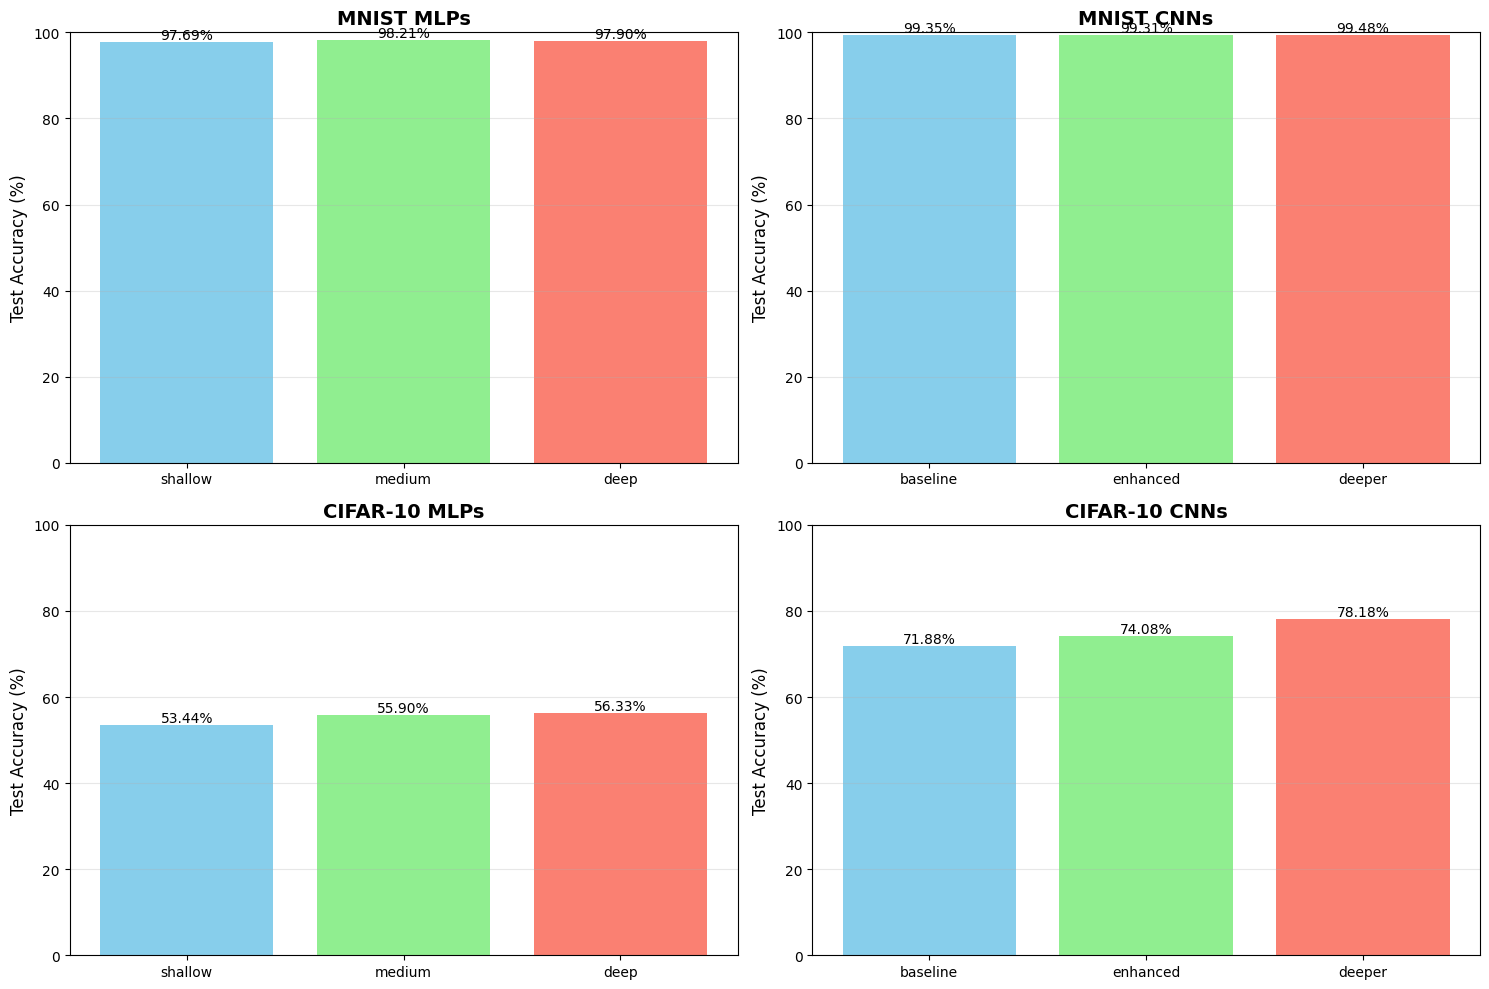

Comparison plot saved as 'results_comparison.png'


In [ ]:
# Create comparison plots
def plot_comparison(mnist_mlp, mnist_cnn, cifar_mlp, cifar_cnn):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # Extract test accuracies
    datasets = ['MNIST MLPs', 'MNIST CNNs', 'CIFAR-10 MLPs', 'CIFAR-10 CNNs']
    results_list = [mnist_mlp, mnist_cnn, cifar_mlp, cifar_cnn]

    for idx, (ax, dataset, results) in enumerate(zip(axes.flat, datasets, results_list)):
        archs = list(results.keys())
        test_accs = [results[arch]['test_accuracy'] for arch in archs]

        bars = ax.bar(archs, test_accs, color=['skyblue', 'lightgreen', 'salmon'])
        ax.set_ylabel('Test Accuracy (%)', fontsize=12)
        ax.set_title(dataset, fontsize=14, fontweight='bold')
        ax.set_ylim([0, 100])
        ax.grid(axis='y', alpha=0.3)

        # Add value labels on bars
        for bar in bars:
            height = bar.get_height()
            ax.text(bar.get_x() + bar.get_width()/2., height,
                   f'{height:.2f}%',
                   ha='center', va='bottom', fontsize=10)

    plt.tight_layout()
    plt.savefig('results_comparison.png', dpi=150, bbox_inches='tight')
    plt.show()
    print("Comparison plot saved as 'results_comparison.png'")

plot_comparison(mnist_mlp_results, mnist_cnn_results,
               cifar_mlp_results, cifar_cnn_results)

In [ ]:
# Print key insights
print("\n" + "="*80)
print("KEY INSIGHTS")
print("="*80)

# Best models
print("\n1. BEST PERFORMING MODELS:")
mnist_best_mlp = max(mnist_mlp_results.items(), key=lambda x: x[1]['test_accuracy'])
mnist_best_cnn = max(mnist_cnn_results.items(), key=lambda x: x[1]['test_accuracy'])
cifar_best_mlp = max(cifar_mlp_results.items(), key=lambda x: x[1]['test_accuracy'])
cifar_best_cnn = max(cifar_cnn_results.items(), key=lambda x: x[1]['test_accuracy'])

print(f"   MNIST MLP: {mnist_best_mlp[0]} - {mnist_best_mlp[1]['test_accuracy']:.2f}%")
print(f"   MNIST CNN: {mnist_best_cnn[0]} - {mnist_best_cnn[1]['test_accuracy']:.2f}%")
print(f"   CIFAR-10 MLP: {cifar_best_mlp[0]} - {cifar_best_mlp[1]['test_accuracy']:.2f}%")
print(f"   CIFAR-10 CNN: {cifar_best_cnn[0]} - {cifar_best_cnn[1]['test_accuracy']:.2f}%")

# CNN vs MLP improvement
print("\n2. CNN IMPROVEMENT OVER MLP:")
mnist_improvement = mnist_best_cnn[1]['test_accuracy'] - mnist_best_mlp[1]['test_accuracy']
cifar_improvement = cifar_best_cnn[1]['test_accuracy'] - cifar_best_mlp[1]['test_accuracy']
print(f"   MNIST: +{mnist_improvement:.2f}% absolute improvement")
print(f"   CIFAR-10: +{cifar_improvement:.2f}% absolute improvement")

print("\n" + "="*80 + "\n")


KEY INSIGHTS

1. BEST PERFORMING MODELS:
   MNIST MLP: medium - 98.21%
   MNIST CNN: deeper - 99.48%
   CIFAR-10 MLP: deep - 56.33%
   CIFAR-10 CNN: deeper - 78.18%

2. CNN IMPROVEMENT OVER MLP:
   MNIST: +1.27% absolute improvement
   CIFAR-10: +21.85% absolute improvement




In [ ]:
# Save all results to a file for the report
import json

# Convert results to serializable format
def results_to_dict(results_dict):
    serializable = {}
    for arch, results in results_dict.items():
        serializable[arch] = {
            'best_config': results['best_config'],
            'test_accuracy': float(results['test_accuracy']),
            'training_time': float(results['training_time']),
            'search_results': results['search_results'].to_dict('records')
        }
    return serializable

all_results = {
    'MNIST_MLP': results_to_dict(mnist_mlp_results),
    'MNIST_CNN': results_to_dict(mnist_cnn_results),
    'CIFAR10_MLP': results_to_dict(cifar_mlp_results),
    'CIFAR10_CNN': results_to_dict(cifar_cnn_results)
}

with open('all_results.json', 'w') as f:
    json.dump(all_results, f, indent=2)

print("All results saved to 'all_results.json'")
print("\n" + "="*80)
print("EXPERIMENT COMPLETE!")
print("="*80)

All results saved to 'all_results.json'

EXPERIMENT COMPLETE!
